Install the Transformers, Datasets, and Evaluate libraries to run this notebook.

In [ ]:
%%capture
!pip install datasets evaluate transformers[sentencepiece] 
!pip install accelerate 
!pip install seqeval py3nvml
!apt install git-lfs

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader

import numpy as np
import pandas as pd

from transformers import AutoTokenizer, AutoModelForTokenClassification, DataCollatorForTokenClassification, TrainingArguments, Trainer, IntervalStrategy, EarlyStoppingCallback, PushToHubCallback 
from datasets import Dataset, DatasetDict, load_dataset
import evaluate

import nltk
from nltk import word_tokenize
nltk.download('punkt')

from collections import Counter
import json
import random
from tqdm import tqdm
import time

random.seed(40) # set random seed to make reproducible
#We have not used 40 as seed value.

You will need to setup git, adapt your email and name in the following cell.

In [ ]:
!git config --global user.email "username@gmail.com"
!git config --global user.name "FirstName LastName"

### Login to HuggingFace if you want to push your trained model to hub

In [ ]:
from huggingface_hub import notebook_login
notebook_login()

Token is valid.
Your token has been saved in your configured git credential helpers (store).
Your token has been saved to /root/.cache/huggingface/token
Login successful


## Loading and Preparing Dataset

You can use our prepared dataset loaded on huggingface datasets.

### `dataset = load_dataset('kanak8278/food_recipe_ner_v2')`
 

In [ ]:
dataset_file = "/content/annotations_combined_v2.csv"

Load the dataset file.

In [ ]:
df = pd.read_csv(dataset_file)
df.columns, df.shape

(Index(['ids', 'instructions', 'Verbs'], dtype='object'), (8898, 3))

In [ ]:
df.head()

,ids,instructions,Verbs
0,10b96d6963,Heat oven to 350 degrees Fahrenheit.,heat
1,10b96d6963,Line baking sheet with parchment paper.,line
2,10b96d6963,Place sun-dried tomatoes and boiling water in ...,"place,boiling"
3,10b96d6963,Cover,cover
4,10b96d6963,let stand 5 minutes or until soft.,stand


We have `instructions` and `Verbs` columns.
The `instructions` column contain individual sentences from different steps in a recipe and the `Verbs` column contain different **Action Verbs** (PROC) in the process. We used nltk to tokenize both the instruction sentence and the verbs. All the words in action verbs is labelled as **PROC** (Process) and others are labelled as **O** (Other).

In [ ]:
results = []
labels_map = {0:'O', 1:'PROC'}
for idx, row in enumerate(df.iterrows()):
  try:
    instruction = word_tokenize(row[1]['instructions'].lower())
  except:
    
    print("Error in Instruction!")
    print(row[1]['instructions'])
    print(idx)
    print()
    continue
  try:
    verbs = [word for verb in row[1]['Verbs'].lower().split(",") for word in word_tokenize(verb)]
  except:
    verbs = []
    print("Error in Verb!")
    print(row[1]['Verbs'])
    print(idx)
    print()

  ner_tag = []
  for word in instruction:
    if word in verbs:
      ner_tag.append(1)
    else:
      ner_tag.append(0)
  # if len(verbs) > 1:
  #   print(instruction)
  #   print(verbs)
  #   print(ner_tag)
  #   print()
  results.append({"tokens": instruction, "ner_tags": ner_tag, "ner_map": [labels_map[i] for i in ner_tag]})
  



Error in Instruction!
nan
518

Error in Verb!
nan
723

Error in Verb!
nan
882

Error in Verb!
nan
888

Error in Verb!
nan
2102

Error in Verb!
nan
3143

Error in Verb!
nan
4239

Error in Verb!
nan
4659

Error in Verb!
nan
6062

Error in Verb!
nan
6643

Error in Verb!
nan
6646

Error in Verb!
nan
6717

Error in Verb!
nan
6849

Error in Verb!
nan
7197

Error in Verb!
nan
7442

Error in Verb!
nan
7647

Error in Verb!
nan
7650

Error in Verb!
nan
7955

Error in Verb!
nan
8518

Error in Verb!
nan
8726

Error in Verb!
nan
8769



Few Instructions and Verbs are found to be empty `nan`. We filter out those data points.

In [ ]:
results[0]

{'tokens': ['heat', 'oven', 'to', '350', 'degrees', 'fahrenheit', '.'],
 'ner_tags': [1, 0, 0, 0, 0, 0, 0],
 'ner_map': ['PROC', 'O', 'O', 'O', 'O', 'O', 'O']}

The prepared dataset contains three things:
1. `tokens`: The Sentence divided into word tokens.
2. `ner_tags`: NER Label (0, 1) corresponding to each word token in `tokens`. 
3. `ner_map`: NER Label Map ('O', 'PROC') corresponding to each word token in `tokens`.

In [ ]:
random.shuffle(results)

Shuffling the dataset before train-test split.

Creating the train-test split and saving the splits and loading to huggingface hub.

In [ ]:
data_df = pd.DataFrame(results)

In [ ]:
data_df.shape, data_df.columns

((8897, 3), Index(['tokens', 'ner_tags', 'ner_map'], dtype='object'))

In [ ]:
dct = {'tokens':data_df['tokens'], 'ner_tags':data_df['ner_tags'], 'ner_map':data_df['ner_map']}

In [ ]:
dataset = Dataset.from_dict(dct)
dataset

Dataset({
    features: ['tokens', 'ner_tags', 'ner_map'],
    num_rows: 8897
})

Creating train-test split `80-20`.

In [ ]:
train_dataset, validation_dataset= dataset.train_test_split(test_size=0.2).values()
train_dataset, validation_dataset

(Dataset({
     features: ['tokens', 'ner_tags', 'ner_map'],
     num_rows: 7117
 }),
 Dataset({
     features: ['tokens', 'ner_tags', 'ner_map'],
     num_rows: 1780
 }))

Creating the `DatasetDict`. 

In [ ]:
dataset = DatasetDict({'train': train_dataset, 'val': validation_dataset})
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'ner_map'],
        num_rows: 7117
    })
    val: Dataset({
        features: ['tokens', 'ner_tags', 'ner_map'],
        num_rows: 1780
    })
})

Saving the train-test split.

In [ ]:
for split, data in dataset.items():
    data.to_json(f"instruction_ner_{split}.jsonl")

Creating json from Arrow format:   0%|          | 0/7 [00:00<?, ?ba/s]

Creating json from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Expecting that login to huggingface_hub was successful earlier.

```
from huggingface_hub import notebook_login
notebook_login()
```



```
dataset.push_to_hub('USERNAME/food_recipe_ner_v2')
```



In [ ]:
USERNAME = "your_username" #username at huggingface.
dataset.push_to_hub(f'{USERNAME}/food_recipe_ner_v2')

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/8 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Upload 1 LFS files:   0%|          | 0/1 [00:00<?, ?it/s]

Deleting unused files from dataset repository:   0%|          | 0/1 [00:00<?, ?it/s]

## NER Training

In [ ]:
# Our processed data and train-test split
dataset = load_dataset('kanak8278/food_recipe_ner_v2')
labels_map = {0:'O', 1:'PROC'}

Extracting data files:   0%|          | 0/2 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/7117 [00:00<?, ? examples/s]

Generating val split:   0%|          | 0/1780 [00:00<?, ? examples/s]

Dataset parquet downloaded and prepared to /root/.cache/huggingface/datasets/kanak8278___parquet/kanak8278--food_recipe_ner_v2-94b2b1c8ca216815/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [ ]:
"""Uncomment below lines if want to use your data for training"""

# USERNAME = "your_username"
# dataset = load_dataset(f'{USERNAME}/food_recipe_ner_v2')
# labels_map = {0:'O', 1:'PROC'}

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['tokens', 'ner_tags', 'ner_map'],
        num_rows: 7117
    })
    val: Dataset({
        features: ['tokens', 'ner_tags', 'ner_map'],
        num_rows: 1780
    })
})

Counting the `PROC` and 'O' for creating weights to be used in training. 

In [ ]:
counter = dict(Counter([val for l in dataset['train']['ner_tags'] for val in l]))

Counter({1: 10443, 0: 76641})

In [ ]:
w = counter[1]/(counter[1]+counter[2])
weights = [w, 1-w]
weights

[0.11991869918699187, 0.8800813008130082]

In [ ]:
raw_datasets = dataset

In [ ]:
label_names = list(labels_map.values())
label_names

['O', 'PROC']

Print the dataset row and check if everything seems correct.

In [ ]:
idx = 10
words = raw_datasets["train"][idx]["tokens"]
labels = raw_datasets["train"][idx]["ner_tags"]
line1 = ""
line2 = ""
for word, label in zip(words, labels):
    full_label = label_names[label]
    max_length = max(len(word), len(full_label))
    line1 += word + " " * (max_length - len(word) + 1)
    line2 += full_label + " " * (max_length - len(full_label) + 1)

print(line1)
print(line2)

philadelphia cream cheese , softened , on bottom of 9-inch pie plate . 
O            O     O      O O        O O  O      O  O      O   O     O 


Creating `id2label` and `label2id` maps. 

In [ ]:
id2label = {i: label for i, label in enumerate(label_names)}
label2id = {v: k for k, v in id2label.items()}

In [ ]:
id2label, label2id

({0: 'O', 1: 'PROC'}, {'O': 0, 'PROC': 1})

#### Load your LLM model to finetune for the NER Task.
Find the list of all the models supported by the AutoModelForTokenClassification [here](https://huggingface.co/docs/transformers/model_doc/auto#transformers.AutoModelForTokenClassification)

Loading the toknizer and model for finetuning.

In [ ]:
model_checkpoint = "xlnet-large-cased"
# model_checkpoint = "google/electra-large-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

In [ ]:
model = AutoModelForTokenClassification.from_pretrained(
    model_checkpoint,
    id2label=id2label,
    label2id=label2id,
)

Some weights of the model checkpoint at xlnet-large-cased were not used when initializing XLNetForTokenClassification: ['lm_loss.weight', 'lm_loss.bias']
- This IS expected if you are initializing XLNetForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLNetForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLNetForTokenClassification were not initialized from the model checkpoint at xlnet-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


`DataCollator` function to create batches.

In [ ]:
data_collator = DataCollatorForTokenClassification(tokenizer=tokenizer)

Loading the metrics

In [ ]:
metric = evaluate.load("seqeval")


def compute_metrics(eval_preds):
    logits, labels = eval_preds
    predictions = np.argmax(logits, axis=-1)

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    all_metrics = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": all_metrics["overall_precision"],
        "recall": all_metrics["overall_recall"],
        "f1": all_metrics["overall_f1"],
        "accuracy": all_metrics["overall_accuracy"],
    }

#### Modifying labels so that the tokenized sub-words have same class label as the untokenzied (complete) word 


In [ ]:
def align_labels_with_tokens(labels, word_ids):
    new_labels = []
    current_word = None
    for word_id in word_ids:
        if word_id != current_word:
            # Start of a new word!
            current_word = word_id
            label = -100 if word_id is None else labels[word_id]
            new_labels.append(label)
        elif word_id is None:
            # Special token
            new_labels.append(-100)
        else:
            # Same word as previous token
            label = labels[word_id]
            new_labels.append(label)

    return new_labels

#### Function to process the dataset and get the `ner_tags` and `labels`

In [ ]:
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"], truncation=True, is_split_into_words=True
    )
    all_labels = examples["ner_tags"]
    new_labels = []
    for i, labels in enumerate(all_labels):
        word_ids = tokenized_inputs.word_ids(i)
        new_labels.append(align_labels_with_tokens(labels, word_ids))

    tokenized_inputs["labels"] = new_labels
    return tokenized_inputs

In [ ]:
tokenized_datasets = raw_datasets.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=raw_datasets["train"].column_names,
)

Map:   0%|          | 0/7117 [00:00<?, ? examples/s]

Asking to truncate to max_length but no maximum length is provided and the model has no predefined maximum length. Default to no truncation.


Map:   0%|          | 0/1780 [00:00<?, ? examples/s]

#### Checking if everything looks good

In [ ]:
model.config.num_labels

2

In [ ]:
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 7117
    })
    val: Dataset({
        features: ['input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 1780
    })
})

#### Setting Training Arguments

In [ ]:
args = TrainingArguments(
    f"{model_checkpoint}-ner-food-combined-v2",
    # evaluation_strategy="epoch",
    eval_steps= 500,
    evaluation_strategy=IntervalStrategy.STEPS,
    learning_rate=5e-6,
    per_device_train_batch_size = 16,
    per_device_eval_batch_size = 24,
    num_train_epochs=10,
    save_total_limit=1,
    weight_decay=0.01,
    push_to_hub=True,
    load_best_model_at_end = True,
)

#### Setting up EarlyStopping Callback

In [ ]:
early_stopping_callback = EarlyStoppingCallback(3, 0.001)

### Defining a custom `Trainer` class to use in training.

Set or Remove `loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights))` to toggle between Weighted and Un-weighted CrossEntropy Loss.

In [ ]:
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        labels = inputs.get("labels")
        # forward pass
        outputs = model(**inputs)
        logits = outputs.get("logits")
        device = 'cuda' if torch.cuda.is_available() else 'cpu'
        
        # compute custom loss (suppose one has 2 labels with different weights)
        loss_fct = nn.CrossEntropyLoss().to(device)
        # loss_fct = nn.CrossEntropyLoss(weight=torch.tensor(weights))

        # print("DEVICE-LOGITS:", logits.view(-1, self.model.config.num_labels).get_device())
        # print("DEVICE-LABELS:", labels.view(-1).get_device())
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

### Traning the model

In [ ]:
trainer = CustomTrainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["val"],
    data_collator=data_collator,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    callbacks = [early_stopping_callback]
)
trainer.train()

/content/xlnet-large-cased-ner-food-combined-v2 is already a clone of https://huggingface.co/kanak8278/xlnet-large-cased-ner-food-combined-v2. Make sure you pull the latest changes with `repo.git_pull()`.
/usr/local/lib/python3.9/dist-packages/transformers/optimization.py:391: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
You're using a XLNetTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.260600,0.082205,0.797624,0.866361,0.830573,0.971199
1000,0.083700,0.095541,0.765733,0.876353,0.817317,0.968315
1500,0.070600,0.073212,0.832207,0.871357,0.851332,0.975044


/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


Step,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
500,0.260600,0.082205,0.797624,0.866361,0.830573,0.971199
1000,0.083700,0.095541,0.765733,0.876353,0.817317,0.968315
1500,0.070600,0.073212,0.832207,0.871357,0.851332,0.975044
2000,0.063100,0.068063,0.855397,0.874271,0.864731,0.976859
2500,0.054900,0.071338,0.835622,0.886761,0.860432,0.975364
3000,0.052100,0.069958,0.842501,0.886345,0.863867,0.975862
3500,0.049300,0.072073,0.844444,0.885928,0.864689,0.976325


/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


TrainOutput(global_step=3500, training_loss=0.09060787909371512, metrics={'train_runtime': 2710.0863, 'train_samples_per_second': 26.261, 'train_steps_per_second': 1.642, 'total_flos': 4258891601787600.0, 'train_loss': 0.09060787909371512, 'epoch': 7.87})

#### Getting Results on the Test Split. 

In [ ]:
trainer.evaluate(tokenized_datasets["val"])

/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))


{'eval_loss': 0.06806334108114243,
 'eval_precision': 0.8553971486761711,
 'eval_recall': 0.8742714404662781,
 'eval_f1': 0.8647313156269302,
 'eval_accuracy': 0.9768592687528926,
 'eval_runtime': 20.053,
 'eval_samples_per_second': 88.765,
 'eval_steps_per_second': 3.74,
 'epoch': 7.87}

#### Pushing the trained model to huggingface_hub with the commit_message.
Expecting that login to huggingface_hub was successful earlier.

```
from huggingface_hub import notebook_login
notebook_login()
```

In [ ]:
trainer.push_to_hub(commit_message=f"finetuned with cross entropy and combined dataset")

Several commits (2) will be pushed upstream.
The progress bars may be unreliable.


Upload file runs/Apr11_11-50-42_a63c23b531fe/events.out.tfevents.1681213901.a63c23b531fe.186.0:   0%|         …

Upload file runs/Apr11_11-50-42_a63c23b531fe/events.out.tfevents.1681216631.a63c23b531fe.186.2:   0%|         …

To https://huggingface.co/kanak8278/xlnet-large-cased-ner-food-combined-v2
   64dcd1e..0347b0f  main -> main

   64dcd1e..0347b0f  main -> main

To https://huggingface.co/kanak8278/xlnet-large-cased-ner-food-combined-v2
   0347b0f..be210b1  main -> main

   0347b0f..be210b1  main -> main



'https://huggingface.co/kanak8278/xlnet-large-cased-ner-food-combined-v2/commit/0347b0fa24dac4fad8586fb11677d866696446db'

### Reclaim the used memory

In [ ]:
import torch
import gc

gc.collect()
torch.cuda.empty_cache()

In [ ]:
train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=8,
)
eval_dataloader = DataLoader(
    tokenized_datasets["val"], collate_fn=data_collator, batch_size=8
)

#### Load model from huggingface model checkpoint.

Find our pretrained models here:
1. [kanak8278/xlnet-large-cased-ner-food-combined-v2](https://huggingface.co/kanak8278/xlnet-large-cased-ner-food-combined-v2)
2. [kanak8278/xlnet-large-cased-ner-food-combined-weighted-v2](https://huggingface.co/kanak8278/xlnet-large-cased-ner-food-combined-weighted-v2)
3. [kanak8278/electra-large-discriminator-ner-food-combined-v2](https://huggingface.co/kanak8278/electra-large-discriminator-ner-food-combined-v2)
4. [kanak8278/electra-large-discriminator-ner-food-combined-weighted-v2](https://huggingface.co/kanak8278/electra-large-discriminator-ner-food-combined-weighted-v2)

In [ ]:
model_checkpoint = f"kanak8278/xlnet-large-cased-ner-food-combined-v2"
model = AutoModelForTokenClassification.from_pretrained(
  model_checkpoint,
  id2label=id2label,
  label2id=label2id,
)

In [ ]:
len(eval_dataloader)

223

In [ ]:
def postprocess(predictions, labels):
    predictions = predictions.detach().cpu().clone().numpy()
    labels = labels.detach().cpu().clone().numpy()

    # Remove ignored index (special tokens) and convert to labels
    true_labels = [[label_names[l] for l in label if l != -100] for label in labels]
    true_predictions = [
        [label_names[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    return true_labels, true_predictions

In [ ]:
model.eval()
metric = evaluate.load("seqeval")

all_preds, all_labels = [], []
eval_time = []



for batch in tqdm(eval_dataloader):
  start = time.time()
  with torch.no_grad():
      outputs = model(**batch)
  eval_time.append(time.time()-start)

  predictions = outputs.logits.argmax(dim=-1)
  labels = batch["labels"]

  
  true_predictions, true_labels = postprocess(predictions, labels)
  
  all_preds.extend(true_predictions)
  all_labels.extend(true_labels)

  0%|          | 0/223 [00:00<?, ?it/s]/usr/local/lib/python3.9/dist-packages/seqeval/metrics/sequence_labeling.py:171: UserWarning: PROC seems not to be NE tag.
  warnings.warn('{} seems not to be NE tag.'.format(chunk))
100%|██████████| 223/223 [00:17<00:00, 12.60it/s]


In [ ]:
total_eval_time = sum(eval_time)
eval_time_per_batch = total_eval_time/len(eval_loader)
total_eval_time, eval_time_per_batch

8.477885007858276

In [ ]:
assert len(all_preds) == len(all_labels)

(1780, 1780)

### Plotting Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [ ]:
grd = [val for l in all_labels for val in l]
pred = [val for l in all_preds for val in l]

assert len(grd) == len(pred)

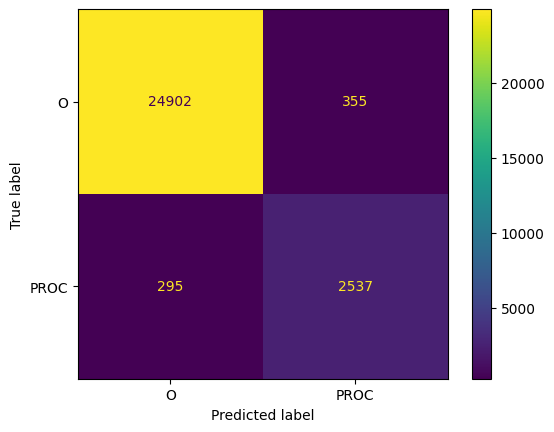

In [ ]:
cm = confusion_matrix(pred, grd, labels=label_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=label_names)
disp.plot()
plt.show()


### Benchmarking the model

In [ ]:
from transformers import PyTorchBenchmark, PyTorchBenchmarkArguments

args = PyTorchBenchmarkArguments(models=["kanak8278/xlnet-large-cased-ner-food-combined-v2"], batch_sizes=[1, 8, 16], sequence_lengths=[32, 128, 512])
benchmark = PyTorchBenchmark(args)

/usr/local/lib/python3.9/dist-packages/transformers/benchmark/benchmark_args_utils.py:136: FutureWarning: The class <class 'transformers.benchmark.benchmark_args.PyTorchBenchmarkArguments'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  warnings.warn(


/usr/local/lib/python3.9/dist-packages/transformers/benchmark/benchmark_utils.py:615: FutureWarning: The class <class 'transformers.benchmark.benchmark.PyTorchBenchmark'> is deprecated. Hugging Face Benchmarking utils are deprecated in general and it is advised to use external Benchmarking libraries  to benchmark Transformer models.
  warnings.warn(


In [ ]:
results = benchmark.run()

1 / 1

====================       INFERENCE - SPEED - RESULT       ====================
--------------------------------------------------------------------------------
          Model Name             Batch Size     Seq Length     Time in s   
--------------------------------------------------------------------------------
kanak8278/xlnet-large-cased-ne       1               32            0.039     
kanak8278/xlnet-large-cased-ne       1              128            0.041     
kanak8278/xlnet-large-cased-ne       1              512             0.2      
kanak8278/xlnet-large-cased-ne       8               32            0.055     
kanak8278/xlnet-large-cased-ne       8              128            0.237     
kanak8278/xlnet-large-cased-ne       8              512            1.946     
kanak8278/xlnet-large-cased-ne       16              32            0.107     
kanak8278/xlnet-large-cased-ne       16             128            0.497     
kanak8278/xlnet-large-cased-ne       16           

In [ ]:
results

BenchmarkOutput(time_inference_result={'kanak8278/xlnet-large-cased-ner-food-combined-v2': {'bs': [1, 8, 16], 'ss': [32, 128, 512], 'result': {1: {32: 0.03852752880000025, 128: 0.04071721549999836, 512: 0.20011028849999946}, 8: {32: 0.05475685360000284, 128: 0.2367643897999983, 512: 1.9460346032000018}, 16: {32: 0.10696320929999956, 128: 0.4973631819000047, 512: 4.1144988813999985}}}}, memory_inference_result={'kanak8278/xlnet-large-cased-ner-food-combined-v2': {'bs': [1, 8, 16], 'ss': [32, 128, 512], 'result': {1: {32: 2451, 128: 2465, 512: 2579}, 8: {32: 2477, 128: 2623, 512: 3583}, 16: {32: 2529, 128: 2807, 512: 4719}}}}, time_train_result={'kanak8278/xlnet-large-cased-ner-food-combined-v2': {'bs': [1, 8, 16], 'ss': [32, 128, 512], 'result': {1: {}, 8: {}, 16: {}}}}, memory_train_result={'kanak8278/xlnet-large-cased-ner-food-combined-v2': {'bs': [1, 8, 16], 'ss': [32, 128, 512], 'result': {1: {}, 8: {}, 16: {}}}}, inference_summary=None, train_summary=None)